# Importing libraries and data

We're using the Titanic dataset, a public aviable dataset 
To check that the algoritm is working, we will follow the following tutorial wich makes feature selection by using RFE with a random forest classifier and cross-validation. We'll then replace the random forest classifier by a SVM and make sure the results stay similar. Then we will implement the RFE portion, with cross-validation, from scartch and again make sure the results stay similar. This should be enough of an indiciation that our algorithm is working for now, but we will realize further testing latter.

Source of the tutorial for the first part: https://www.youtube.com/watch?v=jXSw6em5whI

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

In [82]:
data = pd.read_csv('titanic.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Data cleaning

In [83]:
# Drop clearly useless data
data.drop(['Ticket', 'PassengerId', 'Name'], axis=1, inplace=True)

# Convert data to numeric
data['Sex'].replace({'male': 0, 'female': 1}, inplace=True)
data['Cabin'] = [0 if str(x) == 'nan' else 1 for x in data['Cabin']]

# One Hot Encoding, map a categorical variable to multiple boolean features each.
emb_dummies = pd.get_dummies(data['Embarked'], drop_first=True, prefix='Embarked')
data = pd.concat([data, emb_dummies], axis=1)
data.drop('Embarked', axis=1, inplace=True)

# Fill missung values
data['Age'] = data['Age'].fillna(int(data['Age'].mean()))

In [84]:
data.head(n=10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked_Q,Embarked_S
0,0,3,0,22.0,1,0,7.2500,0,0,1
1,1,1,1,38.0,1,0,71.2833,1,0,0
2,1,3,1,26.0,0,0,7.9250,0,0,1
3,1,1,1,35.0,1,0,53.1000,1,0,1
4,0,3,0,35.0,0,0,8.0500,0,0,1
5,0,3,0,29.0,0,0,8.4583,0,1,0
6,0,1,0,54.0,0,0,51.8625,1,0,1
7,0,3,0,2.0,3,1,21.0750,0,0,1
8,1,3,1,27.0,0,2,11.1333,0,0,1
9,1,2,1,14.0,1,0,30.0708,0,0,0


# RandomForest-RFE with CV

In [85]:
X = data.drop('Survived', axis=1)
target = data['Survived']

rfc = RandomForestClassifier()
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(10), scoring='accuracy')
rfecv.fit(X, target)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(), scoring='accuracy')

In [86]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 6


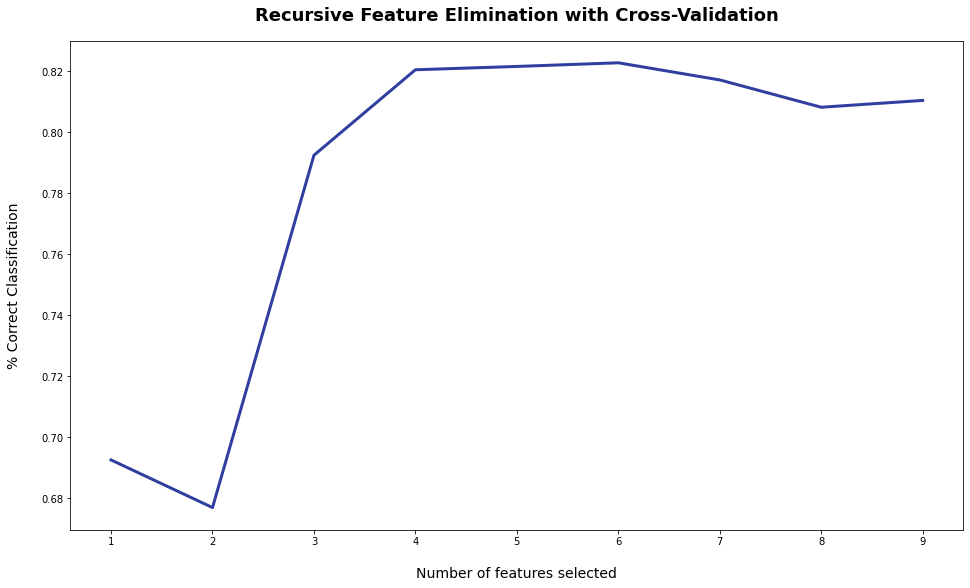

In [87]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)
plt.show()

In [88]:
print(np.where(rfecv.support_ == False)[0])

X.drop(X.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

[4 7 8]


In [89]:
rfecv.estimator_.feature_importances_

array([0.07151772, 0.26217542, 0.27854719, 0.04564226, 0.29492747,
       0.04718995])

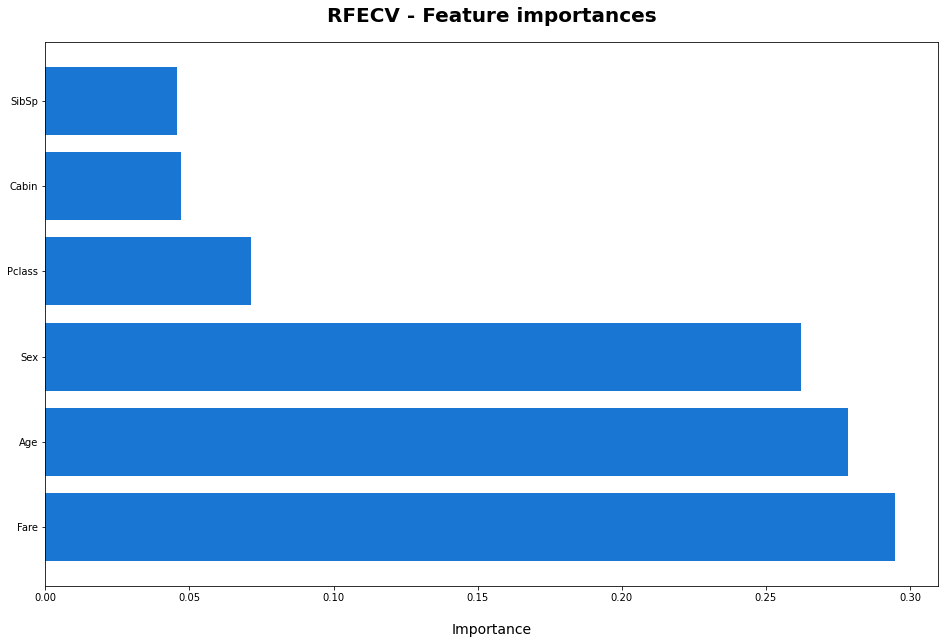

In [90]:
dset = pd.DataFrame()
dset['attr'] = X.columns
dset['importance'] = rfecv.estimator_.feature_importances_
dset = dset.sort_values(by='importance', ascending=False)

plt.figure(figsize=(16, 10))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

# SVM-RFE with CV

In [91]:
X = data.drop('Survived', axis=1)
target = data['Survived']

svc = SVC(kernel="linear")
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2), scoring='accuracy')
rfecv.fit(X, target)

RFECV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
      estimator=SVC(kernel='linear'), scoring='accuracy')

In [92]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 1


In [93]:
rfecv.grid_scores_

array([0.78673855, 0.78673855, 0.76431703, 0.76655918, 0.76655918,
       0.78673855, 0.78337532, 0.77889102, 0.78673855])

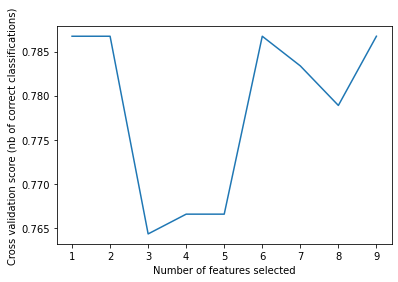

In [94]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1),
         rfecv.grid_scores_)
plt.show()

In [95]:
print(np.where(rfecv.support_ == False)[0])

X.drop(X.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

[0 2 3 4 5 6 7 8]


In [96]:
rfecv.coef_

AttributeError: 'RFECV' object has no attribute 'coef_'

In [ ]:
dset = pd.DataFrame()
dset['attr'] = X.columns
dset['importance'] = rfecv.grid_scores_
dset = dset.sort_values(by='importance', ascending=False)

plt.figure(figsize=(16, 10))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()